In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import yfinance as yf
from scipy.stats import norm

In [2]:
ticker = "TRP.RO"
start_date = '2021-01-01'

In [3]:
try:
    stock = yf.Ticker(ticker)
    df = stock.history(period="max")
except Exception as e:
    print("Error downloading", e)
    df = None
if df is None or df.empty:
    raise ValueError(f"No data returned for {ticker}")
if "Adj Close" in df.columns:
    df = df[["Adj Close"]].rename(columns={"Adj Close": "stock"})
else:
    df = df[["Close"]].rename(columns={"Close": "stock"})

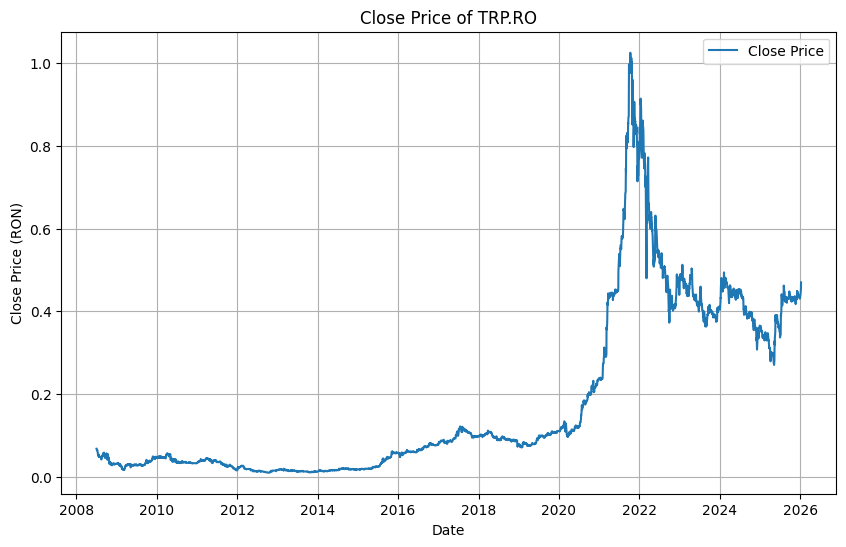

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['stock'], label = 'Close Price')
plt.title(f'Close Price of {ticker}')
plt.xlabel('Date')
plt.ylabel('Close Price (RON)')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
log_ret = np.log(df['stock'] / df['stock'].shift(1))
log_ret = log_ret.dropna()
#print(log_ret.tail())

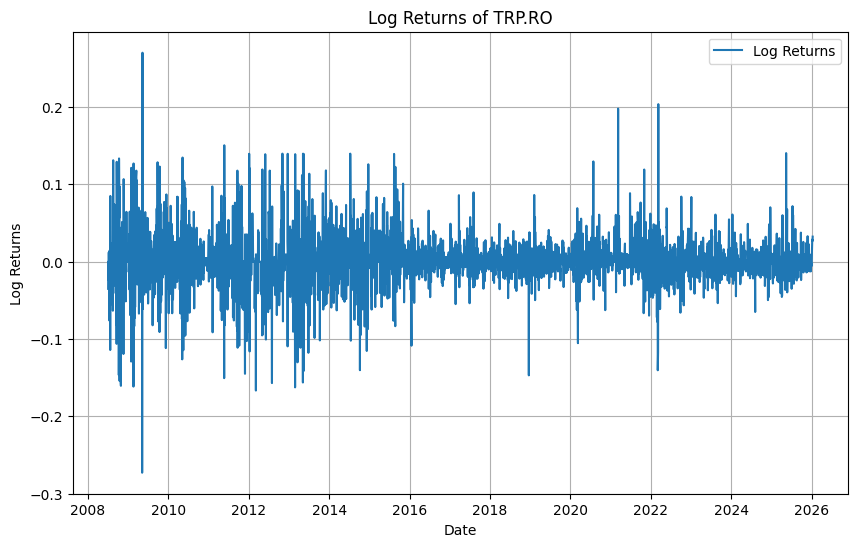

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(log_ret, label='Log Returns')
plt.title(f'Log Returns of {ticker}')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

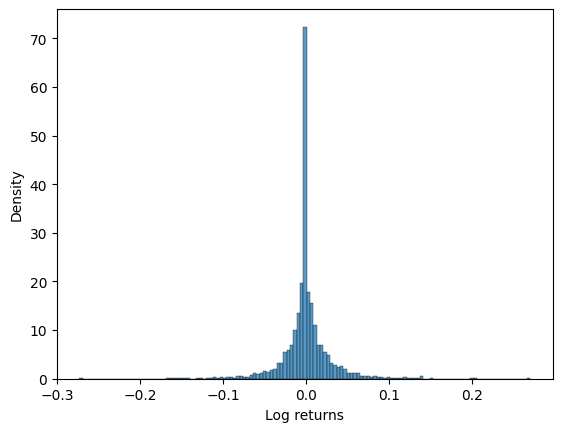

In [7]:
sbn.histplot(log_ret, kde=False, stat='density', label='Log-returns')
plt.xlabel("Log returns")
plt.ylabel("Density")
plt.show()

In [8]:
p = (log_ret != 0).mean()
sigma = log_ret[log_ret != 0].std()
mu = log_ret[log_ret !=0].mean()

In [9]:
daily_vol = np.std(log_ret)
#print(daily_vol)

In [10]:
num_sim = 1000
num_days = 100

In [11]:
last = df['stock'].iloc[-1]
price_path = np.zeros((num_days +1, num_sim))
price_path[0] = last

In [12]:
for t in range(1, num_days + 1):
    trade_today = np.random.rand(num_sim) < p
    shocks = np.random.normal(mu, sigma, num_sim)
    price_path[t] = price_path[t-1]
    price_path[t, trade_today] = price_path[t-1, trade_today] * np.exp(shocks[trade_today])

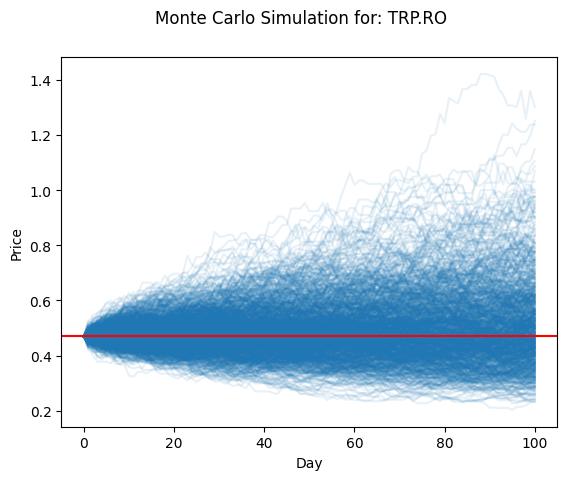

In [13]:
plt.plot(price_path, alpha=0.1, color='tab:blue')
plt.suptitle(f'Monte Carlo Simulation for: {ticker}')
plt.axhline(y = last, color = 'r', linestyle= '-')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

In [14]:
final_prices = price_path[-1]
target = last * 1.05 #prob sa creasca 5%
prob_above = np.mean(final_prices > target)
print(f"Probability price > {target:.3f}: {prob_above:.3%}")

Probability price > 0.493: 48.200%


In [15]:
ci_50 = np.percentile(final_prices, [25, 75])
ci_90 = np.percentile(final_prices, [5, 95])
ci_95 = np.percentile(final_prices, [2.5, 97.5])
print(f"50% confidence interval: {ci_50}")
print(f"90% confidence interval: {ci_90}")
print(f"95% confidence interval: {ci_95}")

50% confidence interval: [0.39885717 0.59325401]
90% confidence interval: [0.30482268 0.80932412]
95% confidence interval: [0.28374809 0.92140682]


In [16]:
mean_price = final_prices.mean()
median_price = np.median(final_prices)
hist, bins = np.histogram(final_prices, bins=50)
mode_price = bins[np.argmax(hist)]
print(f"Mean: {mean_price:.3f}, Median: {median_price:.3f}, Mode: {mode_price:.3f}")

Mean: 0.510, Median: 0.485, Mode: 0.424


In [17]:
crash_level = last * 0.9  # scadere de 10%
prob_crash = np.mean(final_prices < crash_level)
print(f"Probability of 10% drop: {prob_crash:.2%}")

Probability of 10% drop: 32.30%


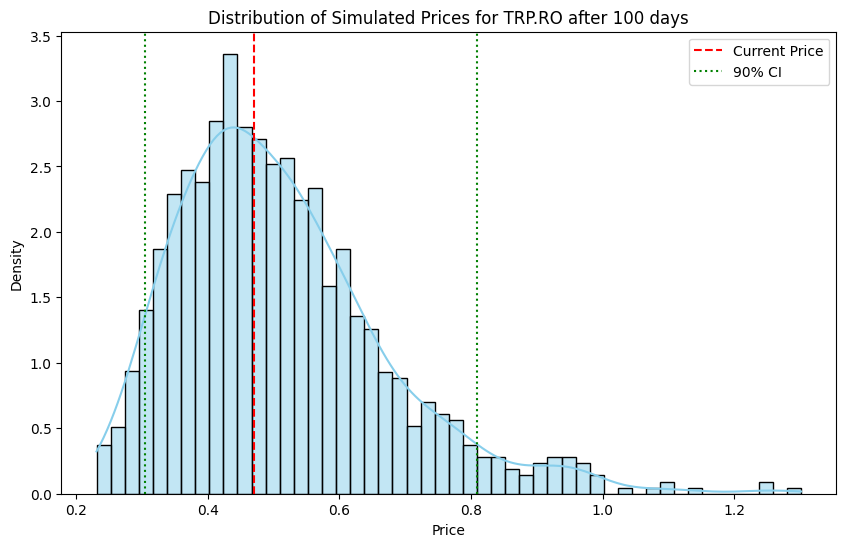

In [18]:
plt.figure(figsize=(10,6))
sbn.histplot(final_prices, bins=50, stat='density', kde=True, color='skyblue')
plt.axvline(last, color='r', linestyle='--', label='Current Price')
plt.axvline(ci_90[0], color='g', linestyle=':', label='90% CI')
plt.axvline(ci_90[1], color='g', linestyle=':')
plt.title(f"Distribution of Simulated Prices for {ticker} after {num_days} days")
plt.xlabel("Price")
plt.ylabel("Density")
plt.legend()
plt.show()